In [1]:
# 2D wedge plots: fix baseline, vary LST and nu
# use 2 14 and 30m baselines
    # pick any baseline that satisfies these conditions
# no averaging over baselines
    # (later, we will want to average over all 30m baselines)
# fringe pattern should repeat 

# will want to parallelize this thing
    # for each baseline
    
# just focus on getting the 3D arrays (LST, nu, response) for each of the two baselines
    # worry about visual representation later
    
%matplotlib inline
import skyflux as sf

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
# Display available antennae
print(sf.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [4]:
min_residual = 100
target = sf.rot.hera_lat
best_i = -1
for i in range(len(sf.catalog.obj_catalog)):
    obj = sf.catalog.obj_catalog[i]
    residual = (obj.dec_angle - target) ** 2
    if residual < min_residual:
        min_residual = residual
        best_i = i
print(best_i)
print(sf.catalog.obj_catalog[best_i])
best_source = sf.catalog.obj_catalog[best_i]
print("Flux at 76MHz:", best_source.flux_by_frq[76])
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

2581
Name: GLEAM J150108-311646
Right ascension: 225.285125
Declination: -30.72038888888889
151 MHz flux: 2.077937

Flux at 76MHz: 3.125759


In [5]:
#S_nu \propto \nu^\alpha
flx = best_source.flux_by_frq

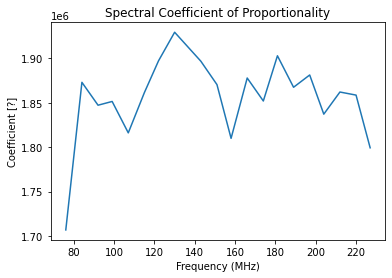

In [6]:
cop = lambda source, nu : source.flux_by_frq[nu / 1e6] / nu ** source.alpha

cops = np.array([cop(best_source, nu * 1e6) for nu in flx])

plt.title("Spectral Coefficient of Proportionality")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Coefficient [?]")
plt.plot(flx.keys(), cops)

In [7]:
ra = np.radians(best_source.ra_angle)
dec = np.radians(best_source.dec_angle)
dec = np.radians(sf.rot.hera_lat)

r = sf.rot.radec2lm(ra, dec, ra0=0)

print(r)

print(sf.ant.baseline(88, 121)[0:2])

(0.6108900225007089, 0.748160993231249)
[-43.92014994  25.13624112]


In [8]:
this_time = np.radians(best_source.ra_angle)

print("Using time:", this_time)

sf.vis.visibility(88, 121, best_source, nu=151e6,
                  time=this_time)[0]

Using time: 3.93196718701699


(2.0779348414660723+0.002885001332471726j)

In [9]:
vist = sf.vis.sources_over_frequency(
    88, 121, best_source, start=76e6, end=227e6, time=this_time
)
#vist

//anaconda3/envs/hera2/lib/python3.8/site-packages/skyflux/vis.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_visibilities.append(np.array([lfreq, next_vista]))


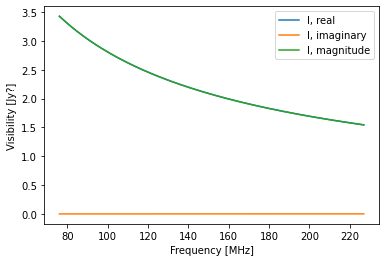

In [10]:
I = np.array([v[1][0] for v in vist])
nu_axis = vist[:, 0] / 1e6

plt.plot(nu_axis, np.real(I), label="I, real")
plt.plot(nu_axis, np.imag(I), label="I, imaginary")
plt.plot(nu_axis, np.abs(I), label="I, magnitude")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

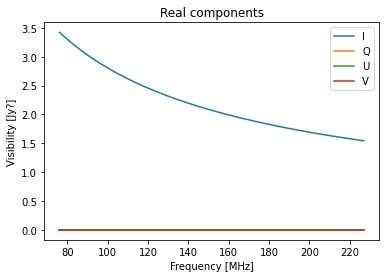

In [11]:
Q = np.array([v[1][1] for v in vist])
U = np.array([v[1][2] for v in vist])
V = np.array([v[1][3] for v in vist])

plt.plot(nu_axis, np.real(I), label="I")
plt.plot(nu_axis, np.real(Q), label="Q")
plt.plot(nu_axis, np.real(U), label="U")
plt.plot(nu_axis, np.real(V), label="V")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Visibility [Jy?]")
plt.title("Real components")

plt.legend()
plt.show()

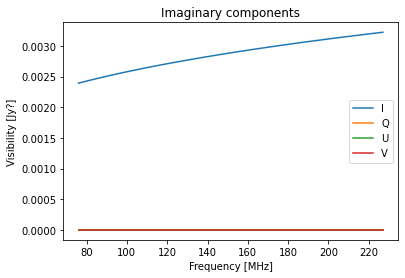

In [12]:
plt.plot(nu_axis, np.imag(I), label="I")
plt.plot(nu_axis, np.imag(Q), label="Q")
plt.plot(nu_axis, np.imag(U), label="U")
plt.plot(nu_axis, np.imag(V), label="V")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Visibility [Jy?]")
plt.title("Imaginary components")

plt.legend()
plt.show()

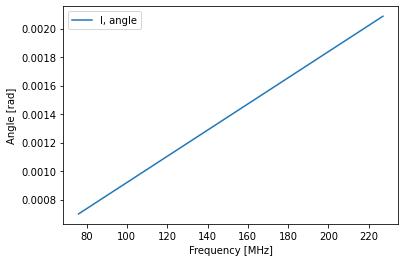

In [13]:
plt.plot(nu_axis, np.angle(I), label="I, angle")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Angle [rad]")

plt.legend()
plt.show()

Right ascension: 3.93196718701699
Frequency interval 1000000.0
Declination: -0.5361719336041936
Reference point: -0.536165146212658
[ 9.99999925e-01+0.j -7.10998239e-08+0.j -9.66431123e-11+0.j
 -1.77882937e-05+0.j]


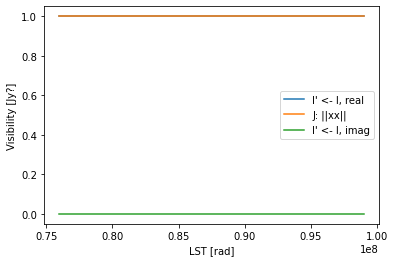

In [14]:
nu_list = [1e6 * i for i in range(76, 100)]

ra = np.radians(best_source.ra_angle)
dec = np.radians(best_source.dec_angle)

# constants for the LST plot
print("Right ascension:", ra)
print("Frequency interval", 1e6)
print("Declination:", dec)
print("Reference point:", np.radians(-30.72))

list_A = []
list_J = []

for nu in nu_list:
    J = sf.stokes.create_J(ra=ra, dec=dec,
                           lst=this_time, nu=nu, radians=True)
    list_J.append(J)
    A = sf.stokes.create_A(J=J)
    list_A.append(A)

list_A = np.array(list_A)
list_J = np.array(list_J)
    
print(list_A[0][0][0])

plt.plot(nu_list, np.real(list_A[:, 0, 0, 0]), label="I' <- I, real")
plt.plot(nu_list, np.abs(list_J[:, 0, 0, 0]), label="J: ||xx||")
plt.plot(nu_list, np.imag(list_A[:, 0, 0, 0]), label="I' <- I, imag")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

In [15]:
print("The following is the universal baseline")
print(sf.ant.baseline(88, 121))

The following is the universal baseline
[-43.92014994  25.13624112  -0.34038648]


In [16]:
len(sf.catalog.obj_catalog)

3872

In [17]:
# Is the frequency making a difference for J and A?
az, alt = sf.rot.eq_to_topo(
    best_source.ra_angle, best_source.dec_angle,
    lst=best_source.ra_angle, radians=False)

az = np.array([np.radians(az)])
alt = np.array([np.radians(alt)])

# format_J has nothing to do with frequency, so theoretically this should directly
# inform us about the influence of the RIMEz code on the Jones matrix
def direct_J(nu):
    return sf.stokes.format_J(sf.stokes.spline_beam_func(nu, alt, az))

In [18]:
direct_J(np.array([151e6]))

array([[[ 7.95616266e-02+9.96829844e-01j,
         -1.10525622e-05-2.50265870e-04j],
        [ 1.10523216e-05+2.50265775e-04j,
          7.95617013e-02+9.96829910e-01j]]])

In [19]:
print(direct_J(np.array([50e6])))
print(direct_J(np.array([51e6])))
print(direct_J(np.array([52e6])))

print(direct_J(50e6))

[[[ 7.95616199e-02+9.96829845e-01j -1.10525763e-05-2.50265825e-04j]
  [ 1.10523357e-05+2.50265730e-04j  7.95616946e-02+9.96829910e-01j]]]
[[[ 7.95616236e-02+9.96829845e-01j -1.10525761e-05-2.50265825e-04j]
  [ 1.10523355e-05+2.50265730e-04j  7.95616983e-02+9.96829910e-01j]]]
[[[ 7.95616212e-02+9.96829845e-01j -1.10525762e-05-2.50265826e-04j]
  [ 1.10523356e-05+2.50265731e-04j  7.95616959e-02+9.96829910e-01j]]]
[[[ 7.95616199e-02+9.96829845e-01j -1.10525763e-05-2.50265825e-04j]
  [ 1.10523357e-05+2.50265730e-04j  7.95616946e-02+9.96829910e-01j]]]


In [20]:
sf.stokes.beam_frqs

array([5.00e+07, 5.10e+07, 5.20e+07, 5.30e+07, 5.40e+07, 5.50e+07,
       5.60e+07, 5.70e+07, 5.80e+07, 5.90e+07, 6.00e+07, 6.10e+07,
       6.20e+07, 6.30e+07, 6.40e+07, 6.50e+07, 6.60e+07, 6.70e+07,
       6.80e+07, 6.90e+07, 7.00e+07, 7.10e+07, 7.20e+07, 7.30e+07,
       7.40e+07, 7.50e+07, 7.60e+07, 7.70e+07, 7.80e+07, 7.90e+07,
       8.00e+07, 8.10e+07, 8.20e+07, 8.30e+07, 8.40e+07, 8.50e+07,
       8.60e+07, 8.70e+07, 8.80e+07, 8.90e+07, 9.00e+07, 9.10e+07,
       9.20e+07, 9.30e+07, 9.40e+07, 9.50e+07, 9.60e+07, 9.70e+07,
       9.80e+07, 9.90e+07, 1.00e+08, 1.01e+08, 1.02e+08, 1.03e+08,
       1.04e+08, 1.05e+08, 1.06e+08, 1.07e+08, 1.08e+08, 1.09e+08,
       1.10e+08, 1.11e+08, 1.12e+08, 1.13e+08, 1.14e+08, 1.15e+08,
       1.16e+08, 1.17e+08, 1.18e+08, 1.19e+08, 1.20e+08, 1.21e+08,
       1.22e+08, 1.23e+08, 1.24e+08, 1.25e+08, 1.26e+08, 1.27e+08,
       1.28e+08, 1.29e+08, 1.30e+08, 1.31e+08, 1.32e+08, 1.33e+08,
       1.34e+08, 1.35e+08, 1.36e+08, 1.37e+08, 1.38e+08, 1.39e

In [21]:
#sf.stokes.spline_beam_func(np.array([0]), np.array([0]), np.array([0]))